In [1]:
# note: fdfdpy must be in your JUPYTER_PATH for this import to work (or you can manually add it to path with some google=able code.)
from fdfdpy.Fdfd import Fdfd
from nonlinear_solvers import born_solve, newton_solve
from optimization import run_optimization

import numpy as np
import matplotlib.pylab as plt
import scipy.sparse as sp

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
omega = 5e14                # angular frequency (2pi)
dl = 1e-1                   # grid size (m)
eps_r = np.ones((100,100))  # relative permittivity
eps_r[40:60, 40:60] = 5     # define box
NPML = [10, 10]             # number of pml grid points on x and y borders
pol = 'Ez'                  # polarization (either 'Hz' or 'Ez')

In [3]:
# sets simulation variables, constructs system matrix 'A', stored in 'simulation' object
simulation = Fdfd(omega,eps_r,dl,NPML,pol)

In [4]:
# set source and solve for electromagnetic fields
b = np.zeros((simulation.Nx,simulation.Ny))
b[40:60,30] = 1
(Hx,Hy,Ez) = simulation.solve_fields(b)

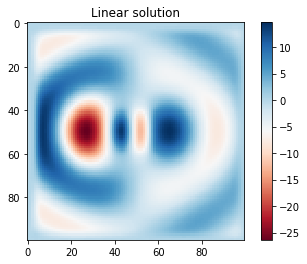

In [5]:
# plot
plt.imshow(np.real(Ez), cmap='RdBu')
plt.colorbar()
plt.title('Linear solution')
plt.show()

In [6]:
n2 = 10                         # Nonlinearity strength
nl_region = np.zeros(eps_r.shape)  # Nonliearity region
nl_region[40:60, 40:60] = 1
# Define nonlinear function
nonlinear_fn = lambda e: n2*np.square(np.abs(e))

In [7]:
# This is where we define stuff for the optimization

eps_max = 5
Nsteps = 10
Jregion = np.zeros(eps_r.shape)
Jregion[50, 80] = 1

# define linear and nonlinear parts of objective function + the total objective function form
J = {}
J['linear']    = lambda e: np.sum(np.square(np.abs(e*Jregion)))
J['nonlinear'] = None
J['total']     = lambda Jlin, Jnonlin: Jlin

# define linear and nonlinear parts of dJdE + the total derivative form
dJdE = {}
dJdE['linear']    = lambda e: np.conj(e)*Jregion
dJdE['nonlinear'] = None
dJdE['total']     = lambda dJdE_lin, dJdE_nonlin: dJdE_lin

design_region = np.array(eps_r > 1).astype(int)

In [8]:
obj_fns = run_optimization(simulation, b, J, dJdE, design_region, Nsteps, eps_max, solver='born', step_size=0.2)

100% (10 of 10) |########################| Elapsed Time: 0:00:00 ETA:  00:00:00

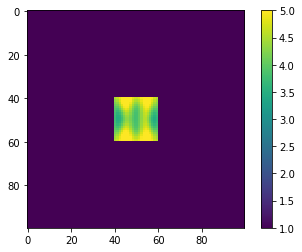

In [9]:
plt.imshow(simulation.eps_r)
plt.colorbar()
plt.show()

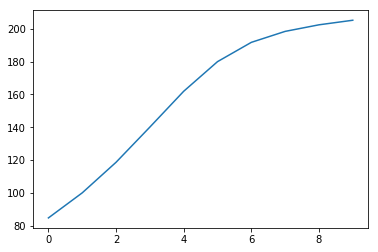

In [10]:
plt.plot(obj_fns)
plt.show()

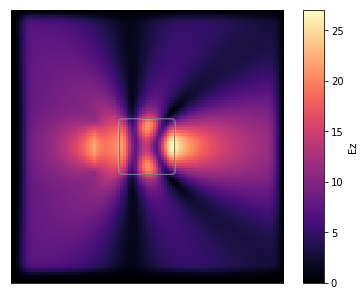

In [11]:
(Hx,Hy,Ez) = simulation.solve_fields(b)
simulation.plt_abs()